# Imports

In [1]:
!pip install transformers

You should consider upgrading via the 'C:\Users\Legion\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import os
from tqdm import tqdm

import operator
import gc

from transformers import GPT2Tokenizer, T5ForConditionalGeneration

from sklearn.model_selection import train_test_split

import pickle
import json

import datetime
import pytz

NameError: name 'drive' is not defined

In [ ]:
!huggingface-cli login

# Constants

In [5]:
SEED = 42

# Paths
DRIVE_PATH = './gdrive/MyDrive/RuTextNormalization'
TRAIN_FILE_NAME = 'train.csv'
TEST_FILE_NAME = 'test.csv'
TEST2_FILE_NAME = 'test_2.csv'

SUBMISSION_FILE_NAME = 'sample_submission.csv'
DATA_PATH = DRIVE_PATH + '/data'
SUBS_PATH = DRIVE_PATH + '/submits'
NOTEBOOKS_PATH = DRIVE_PATH + '/notebooks'
MODELS_PATH = DRIVE_PATH + '/models'

# Train data
BATCH_SIZE = 8

DEL_TOKEN = "␞"

In [6]:
EXAMPLES = [
    {
        "input": "По␞состоянию␞на␞1862␞год␞.",
        "output": "По␞состоянию␞на␞тысяча восемьсот шестьдесят второй год␞год␞."
    },
    {
        "input": "A␞new␞family␞of␞planets",
        "output": "a_latin␞н_trans ь_trans ю_trans␞ф_trans э_trans м_trans и_trans л_trans и_trans␞о_trans ф_trans␞п_trans л_trans а_trans н_trans е_trans т_trans с_trans"
    },
    {
        "input": "240␞75 мм",
        "output": "двухсот сорока␞семьдесят пять миллиметров"
    },
    {
        "input": "1 декабря 2014",
        "output": "первого декабря две тысячи четырнадцатого года"
    },
    {
        "input": "1864 г.␞стр␞189",
        "output": "тысяча восемьсот шестьдесят четвертый год␞с т р␞сто восемьдесят девять"
    },
    {
        "input": "XIX␞1846",
        "output": "девятнадцатом␞тысяча восемьсот сорок шесть"
    },
    {
        "input": "1920-х␞1930-х",
        "output": "тысяча девятьсот двадцатых␞тысяча девятьсот тридцатых"
    },
    {
        "input": "1-ю␞1915 год",
        "output": "первую␞тысяча девятьсот пятнадцатый год"
    },
    {
        "input": "3,25 км².",
        "output": "трех целых и двадцати пяти сотых квадратного километра"
    },
    {
        "input": "20,0%␞15,0%␞65",
        "output": "двадцать процентов␞пятнадцать процентов␞шестидесяти пяти"
    },
    {
        "input": "ISBN␞5-85270-005-3␞К.␞Е.",
        "output": "i s b n␞пять sil восемьсот пятьдесят два семьдесят sil ноль ноль пять sil три␞к␞е"
    },
    {
        "input": "Rozhlad␞29 (1979) 4␞str",
        "output": "р_trans о_trans з_trans л_trans е_trans д_trans␞двадцать девять sil девятнадцать семьдесят девять sil четыре␞с_trans т_trans р_trans"
    },
    {
        "input": "428,1 тысяч␞458,4 тысячи",
        "output": "четыреста двадцать восемь целых и одна десятая тысячи␞четыреста пятьдесят восемь целых и четыре десятых тысячи"
    },
    {
        "input": "Declaracion␞de␞Mohamed␞Bassir␞1970␞Desaparecidos.org␞Espina␞Barrio␞Angel␞B.␞Emigracion␞e␞Integracion␞Cultural",
        "output": "д_trans е_trans к_trans л_trans а_trans р_trans а_trans с_trans и_trans о_trans н_trans␞д_trans е_trans␞м_trans о_trans х_trans а_trans м_trans е_trans д_trans␞б_trans а_trans с_trans с_trans и_trans р_trans␞тысяча девятьсот семьдесят␞д_trans е_trans с_trans а_trans п_trans а_trans р_trans е_trans с_trans и_trans д_trans о_trans с_trans точка о_trans р_trans г_trans␞э_trans с_trans п_trans и_trans н_trans а_trans␞б_trans а_trans р_trans р_trans и_trans о_trans␞а_trans н_trans д_trans ж_trans е_trans л_trans␞b␞э_trans м_trans и_trans г_trans р_trans а_trans с_trans и_trans о_trans н_trans␞e_latin␞и_trans н_trans т_trans е_trans г_trans р_trans а_trans с_trans и_trans о_trans н_trans␞к_trans а_trans л_trans ч_trans е_trans р_trans э_trans л_trans"
    },
    {
        "input": "14 января 2012␞22 марта␞2012.avn.com␞1995␞winners␞2012",
        "output": "четырнадцатого января две тысячи двенадцатого года␞двадцать второго марта␞две тысячи двенадцать точка а_trans в_trans н_trans точка к_trans о_trans м_trans␞тысячи девятисот девяноста пяти␞у_trans и_trans н_trans н_trans е_trans р_trans с_trans␞две тысячи двенадцать"
    },
    {
        "input": "128,107␞564 $␞100,468␞793 $␞27,638␞771 $",
        "output": "сто двадцать восемь целых и сто семь тысячных␞пятьсот шестьдесят четыре доллара сэ ш а␞сто целых и четыреста шестьдесят восемь тысячных␞семьсот девяносто три доллара сэ ш а␞двадцать семь целых и шестьсот тридцать восемь тысячных␞семьсот семьдесят один доллар сэ ш а"
    },
    {
        "input": "1981 г.␞5 млрд руб.␞1 млрд руб.",
        "output": "тысяча девятьсот восемьдесят первом году␞пять миллиардов рублей␞один миллиард рублей 13/26 -> тринадцать двадцать шестых"
    },
    {
        "input": "16:06 UTC␞Lockheed␞1011-385-1-15␞TriStar␞200␞HZ␞AHK",
        "output": "шестнадцать часов шесть минут по часовому поясу u t c␞л_trans о_trans к_trans х_trans и_trans д_trans␞десять одиннадцать sil триста восемьдесят пять sil один sil пятнадцать␞т_trans р_trans и_trans с_trans т_trans а_trans р_trans␞двести␞h z␞a h k"
    }
]

In [7]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Utils

In [9]:
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_all_seeds(SEED)

In [10]:
def save_submit(submit):
    current_time = datetime.datetime.now(pytz.timezone('Asia/Krasnoyarsk'))
    submit.to_csv(os.path.join(SUBS_PATH, 'sub_' + current_time.strftime("%d_%B_%H:%M") + '.csv'), index=False)

In [11]:
def save_notebook():
    current_time = datetime.datetime.now(pytz.timezone('Asia/Krasnoyarsk'))
    new_name = 'nb_' + current_time.strftime("%d_%B_%H:%M") + '.ipynb'

    notebook_path = os.path.join(DRIVE_PATH, 'solution.ipynb')

    destination_path = f"{NOTEBOOKS_PATH}/{new_name}.ipynb"
    shutil.copy(notebook_path, destination_path)

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Load data

In [13]:
train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_FILE_NAME))
train.head(15)

,sentence_id,token_id,class,before,after
0,0,0,PLAIN,По,По
1,0,1,PLAIN,состоянию,состоянию
2,0,2,PLAIN,на,на
3,0,3,DATE,1862 год,тысяча восемьсот шестьдесят второй год
4,0,4,PUNCT,.,.
5,1,0,PLAIN,Оснащались,Оснащались
6,1,1,PLAIN,латными,латными
7,1,2,PLAIN,рукавицами,рукавицами
8,1,3,PLAIN,и,и
9,1,4,PLAIN,сабатонами,сабатонами


In [14]:
test = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE_NAME))
test.head(15)

,sentence_id,token_id,before
0,0,0,Производится
1,0,1,в
2,0,2,Азии
3,0,3,","
4,0,4,Африке
5,0,5,","
6,0,6,России
7,0,7,","
8,0,8,Турции
9,0,9,","


# EDA

In [15]:
print(f"Total tokens in train: {train.shape[0]}")
print(f"Total sentences in train: {len(train['sentence_id'].unique())}")

Total tokens in train: 10574516
Total sentences in train: 761436


In [16]:
print("Unique domens:")
train['class'].unique()

Unique domens:


array(['PLAIN', 'DATE', 'PUNCT', 'ORDINAL', 'VERBATIM', 'LETTERS',
       'CARDINAL', 'MEASURE', 'TELEPHONE', 'ELECTRONIC', 'DECIMAL',
       'DIGIT', 'FRACTION', 'MONEY', 'TIME'], dtype=object)

<Axes: title={'center': 'Classes of all tokens in data'}, xlabel='Class', ylabel='Count'>

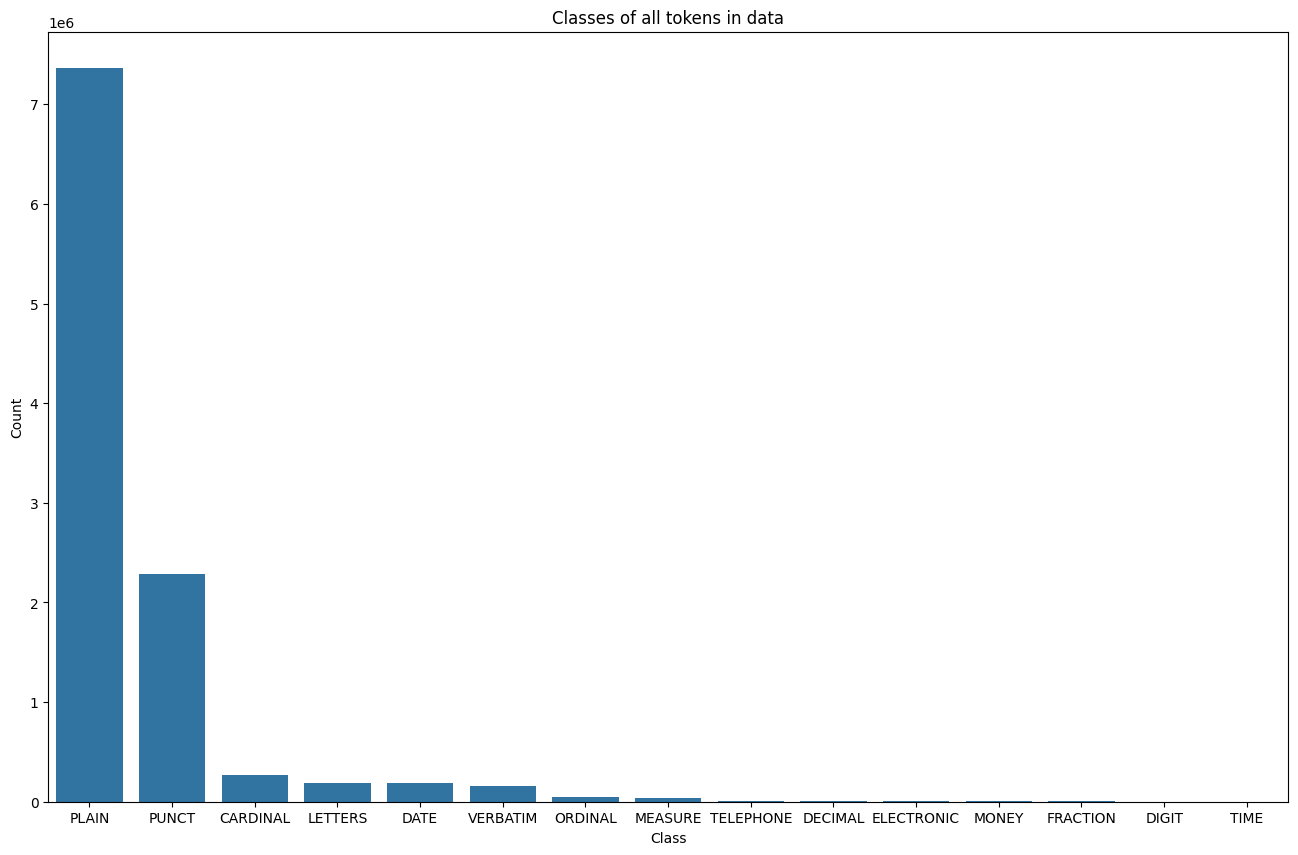

In [17]:
classes_count = train['class'].value_counts()

plt.figure(figsize=(16, 10))
plt.title('Classes of all tokens in data')
plt.xlabel('Class')
plt.ylabel('Count')

sns.barplot(x=classes_count.index, y=classes_count.values)

In [18]:
diff_train = train[train['before'] != train['after']]
diff_train.head(20)

,sentence_id,token_id,class,before,after
3,0,3,DATE,1862 год,тысяча восемьсот шестьдесят второй год
17,2,2,DATE,1811 года,тысяча восемьсот одиннадцатого года
43,3,7,PLAIN,Tiberius,т_trans и_trans б_trans е_trans р_trans и_tran...
44,3,8,PLAIN,Julius,д_trans ж_trans у_trans л_trans и_trans у_tran...
45,3,9,PLAIN,Pollienus,п_trans о_trans л_trans л_trans и_trans е_tran...
46,3,10,PLAIN,Auspex,о_trans с_trans п_trans е_trans к_trans с_trans
53,3,17,ORDINAL,III,третьего
85,6,1,DATE,12 февраля 2013,двенадцатого февраля две тысячи тринадцатого года
90,6,6,DATE,15 февраля 2013,пятнадцатого февраля две тысячи тринадцатого года
92,6,8,LETTERS,TV,t v


<Axes: title={'center': 'Classes of tokens need to be normalized'}, xlabel='Class', ylabel='Count'>

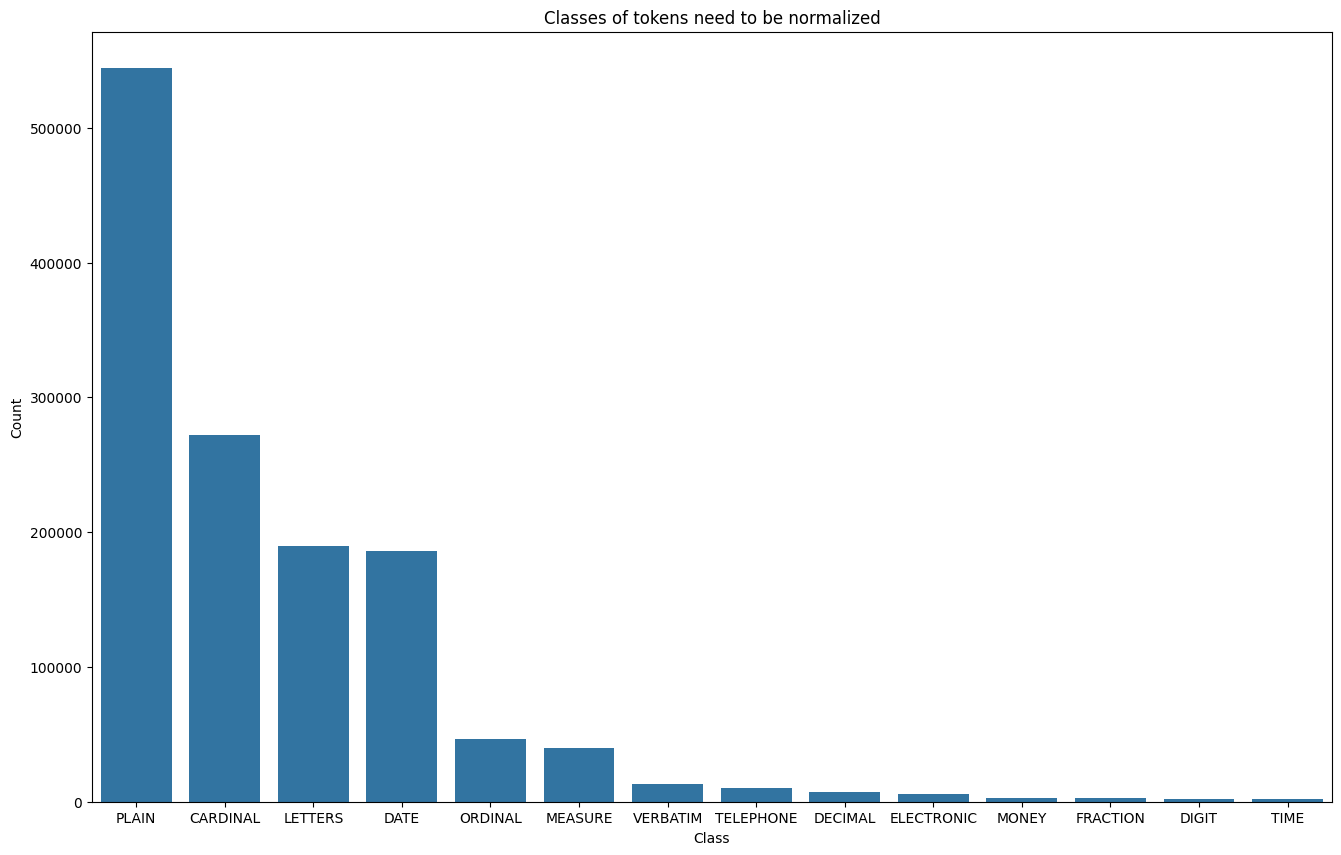

In [19]:
diff_classes_count = diff_train['class'].value_counts()

plt.figure(figsize=(16, 10))
plt.title('Classes of tokens need to be normalized')
plt.xlabel('Class')
plt.ylabel('Count')

sns.barplot(x=diff_classes_count.index, y=diff_classes_count.values)

**PLAIN:** Review -> р_trans е_trans в_trans ь_trans ю_trans	\
**CARDINAL:** 254 -> двести пятьдесят четыре, 2011 - две тысячи одиннадцать \
`LETTERS: Л. Н. -> л н `\
**DATE:** 25 ноября 2012 -> двадцать пятого ноября две тысячи двенадцатого года \
**ORDINAL** XIX	-> девятнадцатого \
**MEASURE:** 2 % -> два процента \
`VERBATIM: α -> альфа `\
**TELEPHONE:** (12) 25 -> двенадцать sil двадцать пять	 \
**DECIMAL:** -5,9	-> минус пять целых **и** девять десятых \
**ELECTRONIC:** Rol.ru -> р_trans о_trans л_trans точка р_trans у_trans, Svt.se	 ->  s v t точка s e	 \
**MONEY:** $70 млн -> семьдесят миллионов долларов сэ ш а \
**FRACTION:** 1 ½ -> одна целая и одна вторая \
`DIGIT: 0144 -> ноль один четыре четыре` \
**TIME:** 23:25 -> двадцать три часа двадцать пять минут, 17:00 -> семнадцать часов



Пример ручного формирования промпта:

In [20]:
sentence_id = 581081
print(DEL_TOKEN.join(list(diff_train[diff_train['sentence_id'] == sentence_id]['before'])))
print(DEL_TOKEN.join(list(diff_train[diff_train['sentence_id'] == sentence_id]['after'])))

16:06 UTC␞Lockheed␞1011-385-1-15␞TriStar␞200␞HZ␞AHK
шестнадцать часов шесть минут по часовому поясу u t c␞л_trans о_trans к_trans х_trans и_trans д_trans␞десять одиннадцать sil триста восемьдесят пять sil один sil пятнадцать␞т_trans р_trans и_trans с_trans т_trans а_trans р_trans␞двести␞h z␞a h k


In [21]:
diff_train[(diff_train['class'] == 'TIME')].sample(20)

,sentence_id,token_id,class,before,after
7430061,535645,23,TIME,19:00,девятнадцать часов
3479569,251587,7,TIME,07.06,семь часов шесть минут
5422267,391360,26,TIME,15:13,пятнадцать часов тринадцать минут
7430055,535645,17,TIME,07:00,семь часов
3301721,238786,9,TIME,14:00,четырнадцать часов
5972918,430841,1,TIME,04:00,четыре часа
4719841,340910,31,TIME,18:16,восемнадцать часов шестнадцать минут
10055631,724142,12,TIME,8:30,восемь часов тридцать минут
3510299,253852,6,TIME,17:40,семнадцать часов сорок минут
5049955,364720,19,TIME,14:25,четырнадцать часов двадцать пять минут


## Searching mistakes in dataset

### Letters class

In [22]:
diff_train[diff_train['class'] == 'LETTERS']

,sentence_id,token_id,class,before,after
92,6,8,LETTERS,TV,t v
186,12,9,LETTERS,РСФСР,р с ф с р
301,24,1,LETTERS,СПб,с п б
340,26,1,LETTERS,СПб,с п б
346,26,7,LETTERS,В. А.,в а
...,...,...,...,...,...
10574343,761424,17,LETTERS,AE,a e
10574345,761424,19,LETTERS,IC,i c
10574392,761429,1,LETTERS,ISBN,i s b n
10574396,761429,5,LETTERS,A.,a


In [23]:
def is_initials(text):
    pattern = r'^([А-ЯA-ZЁ]\.)([\s-]?[А-ЯA-ZЁ]\.){0,5}$'
    return bool(re.fullmatch(pattern, text.strip()))

In [24]:
def is_roman_numeral(text):
    pattern = r'^M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$'
    return bool(re.fullmatch(pattern, text))

In [25]:
value_counts = diff_train[diff_train['class'] == 'LETTERS']['before'].value_counts()
abbreviations = list(filter(lambda x: not is_initials(x) and x != 'NaN' and not is_roman_numeral(x) , value_counts.index.tolist()[:10000]))

In [26]:
with open('abbreviations.json', 'w', encoding='utf-8') as f:
    json.dump(sorted(abbreviations), f, ensure_ascii=False, indent=2)

In [27]:
diff_train[
    (diff_train['class'] == 'LETTERS') &
    (diff_train['before'].apply(
        lambda x: ' '.join(' '.join(str(x).lower().replace('.', '').replace('ё', 'е')).split())
    ) != diff_train['after'])
]

,sentence_id,token_id,class,before,after
334194,24300,2,LETTERS,NaN,n a
2683909,194317,5,LETTERS,NaN,n a
3913980,283009,4,LETTERS,NaN,n a
7380306,532103,4,LETTERS,NaN,n a
9340505,672795,15,LETTERS,NaN,n u l l
9593240,691040,5,LETTERS,NaN,n a
9788249,705037,0,LETTERS,NaN,n a


In [28]:
train.loc[9340505, 'after'] = 'n a'

### MEASURE class

In [29]:
import re

# All types of MEASURE
all_measures = diff_train[diff_train['class'] == 'MEASURE']['before'].apply(lambda x: x.split()[1] if len(x.split()) >= 2 else re.sub(r'^-?\d*[,.]?\d+', '', x))
all_measures

,before
365,st
412,минуту
474,км
605,см.
793,с.
...,...
10572855,метра.
10573131,%
10573718,метров
10574015,с.


In [30]:
all_measures.unique()

array(['st', 'минуту', 'км', 'см.', 'с.', '%', 'метров', 'метров.', 'км.',
       'см3.', 'об/мин.', 'л.', 'К', 'минут.', 'В.', 'мм', 'тыс.', 'т.',
       'м', 'км²', 'километров.', 'минут', 'см', '500', '417', 'км².',
       'километрах', 'ярдов', '000', 'млрд', 'мм.', 'А', 'метра', 'См.',
       'га', 'м.', 'га.', 'ГБ', 'г.', 'тыс.м3.', 'А.', '361', 'кг', 'т',
       'тысяч', 'с', 'мл', 'грамм', 'кВт', 'МПа.', 'В', 'мА.', 'МГц',
       'кГц.', 'км³.', '547', 'кг.', 'млн', 'Gb', '513', 'Н.', 'см³',
       '011', 'Ps', 'мг.', 'ТБ', 'МВт.', 'м³.', 'Ф.', 'тонны.', 'суток.',
       'км/с', 'г', 'недели', 'родов.', 'тонн', 'метрах', 'мкг',
       'центнера', 'ГГц.', '300', 'километров', 'минуты', '700', 'рода',
       'миль.', 'милях', 'cm.', '831', 'КБ', 'об.', 'гектаров.', 'байт',
       'ч.', 'градусов.', 'граммов.', 'км2', 'недели.', 'km/h', 'об',
       'градусов', 'g', 'километра.', 'метра.', '381', '892', 'родов',
       'акров', 'футов', 'м²', 'мин.', 'процентами', 'Гб.', 'Тб.', 'м

### VERBATIM class

In [31]:
diff_train[diff_train['class'] == 'VERBATIM']['before'].unique()

array(['ї', '&', '²', 'є', 'ў', 'Α', 'ν', 'δ', 'ρ', 'ε', 'α', 'ς', 'Μ',
       'π', 'ο', 'υ', 'χ', 'λ', 'κ', 'η', 'Σ', 'τ', 'ι', 'ω', 'σ', 'Κ',
       '#', '_', '~', 'Θ', 'θ', 'ξ', 'γ', 'Π', 'Τ', 'Γ', 'μ', 'Є', 'Δ',
       'Ε', 'Ζ', 'β', 'Φ', 'Β', 'Ι', '%', 'ζ', '³', 'Ї', 'Ν', 'Λ', 'Ψ',
       'φ', '$', 'Ў', 'Ο', 'Χ', 'Υ', '№', 'ψ', 'Ρ', 'Η', 'ґ', '=', '£',
       '×', '−', 'Ω', '«', '.', '+', 'Ξ', 'Ґ'], dtype=object)

In [32]:
diff_train[diff_train['class'] == 'VERBATIM']

,sentence_id,token_id,class,before,after
777,55,2,VERBATIM,ї,и
813,57,11,VERBATIM,&,и
1374,96,29,VERBATIM,&,и
2845,199,8,VERBATIM,&,и
5444,411,7,VERBATIM,&,и
...,...,...,...,...,...
10567593,760932,7,VERBATIM,&,и
10568216,760981,11,VERBATIM,~,тильда
10571155,761184,12,VERBATIM,~,тильда
10572493,761286,20,VERBATIM,$,доллар


In [33]:
diff_train[diff_train['class'] == 'VERBATIM'].groupby('before')['after'].nunique().sort_values(ascending=False)

,after
before,
#,1
$,1
%,1
&,1
+,1
...,...
ў,1
Ґ,1
ґ,1


Можно однозначно проинтерпретировать

Сформируем словарь

In [34]:
verbatim_pairs = diff_train[diff_train['class'] == 'VERBATIM']
before_after_dict = dict(zip(verbatim_pairs['before'], verbatim_pairs['after']))
before_after_dict

{'ї': 'и',
 '&': 'и',
 '²': 'в квадрате',
 'є': 'е',
 'ў': 'у',
 'Α': 'альфа',
 'ν': 'ню',
 'δ': 'дельта',
 'ρ': 'ро',
 'ε': 'эпсилон',
 'α': 'альфа',
 'ς': 'сигма',
 'Μ': 'мю',
 'π': 'пи',
 'ο': 'омикрон',
 'υ': 'ипсилон',
 'χ': 'хи',
 'λ': 'лямбда',
 'κ': 'каппа',
 'η': 'эта',
 'Σ': 'сигма',
 'τ': 'тау',
 'ι': 'йота',
 'ω': 'омега',
 'σ': 'сигма',
 'Κ': 'каппа',
 '#': 'решетка',
 '_': 'нижнее подчеркивание',
 '~': 'тильда',
 'Θ': 'тета',
 'θ': 'тета',
 'ξ': 'кси',
 'γ': 'гамма',
 'Π': 'пи',
 'Τ': 'тау',
 'Γ': 'гамма',
 'μ': 'мю',
 'Є': 'е',
 'Δ': 'дельта',
 'Ε': 'эпсилон',
 'Ζ': 'дзета',
 'β': 'бета',
 'Φ': 'фи',
 'Β': 'бета',
 'Ι': 'йота',
 '%': 'процент',
 'ζ': 'дзета',
 '³': 'в кубе',
 'Ї': 'и',
 'Ν': 'ню',
 'Λ': 'лямбда',
 'Ψ': 'пси',
 'φ': 'фи',
 '$': 'доллар',
 'Ў': 'у',
 'Ο': 'омикрон',
 'Χ': 'хи',
 'Υ': 'ипсилон',
 '№': 'номер',
 'ψ': 'пси',
 'Ρ': 'ро',
 'Η': 'эта',
 'ґ': 'г',
 '=': 'равно',
 '£': 'фунт стерлингов',
 '×': 'умножить на',
 '−': 'минус',
 'Ω': 'омега',
 '«': 'ка

### TELEPHONE

In [35]:
diff_train[diff_train['class'] == 'TELEPHONE'].sample(20)

,sentence_id,token_id,class,before,after
9334824,672383,14,TELEPHONE,978-5-9524-4167-5,девятьсот семьдесят восемь sil пять sil девяно...
2390664,173184,1,TELEPHONE,2015-08-01,двадцать пятнадцать sil ноль восемь sil ноль один
9634051,693963,2,TELEPHONE,978-9975-67-593-2,девятьсот семьдесят восемь sil девяносто девят...
356549,25876,0,TELEPHONE,1938-1946,девятнадцать тридцать восемь sil девятнадцать ...
4456426,322040,2,TELEPHONE,83-841965,восемьдесят три sil восемьсот сорок один девят...
7059772,509146,2,TELEPHONE,5-235-02660-8,пять sil двести тридцать пять sil ноль двадцат...
5715981,412415,17,TELEPHONE,0-312-24011-2,ноль sil триста двенадцать sil двести сорок од...
4615290,333366,8,TELEPHONE,0-9602736-0-3,ноль sil девятьсот шестьдесят двадцать семь тр...
9920762,714487,2,TELEPHONE,5-94538-470-4,пять sil девятьсот сорок пять тридцать восемь ...
10304616,742036,10,TELEPHONE,0-7136-6418-5,ноль sil семьдесят один тридцать шесть sil шес...


Иногда встречаются скобки:

In [36]:
diff_train.loc[4591282]

,4591282
sentence_id,331654
token_id,3
class,TELEPHONE
before,(12) 25
after,двенадцать sil двадцать пять


Где-то четырехзначные числа читаются как два двузначных числа, а где-то почему-то нет

In [37]:
diff_train.loc[248935]

,248935
sentence_id,18051
token_id,1
class,TELEPHONE
before,2009-11-13
after,две тысячи девять sil одиннадцать sil тринадцать


### MONEY class

In [38]:
diff_train[(diff_train['class'] == 'MONEY') & (diff_train['after'].str.endswith('сэ ш а'))]

,sentence_id,token_id,class,before,after
26351,1943,4,MONEY,31 537 USD,тридцать одна тысяча пятьсот тридцать семь дол...
26353,1943,6,MONEY,22 151 USD,двадцати двух тысяч ста пятидесяти одного долл...
37850,2768,9,MONEY,"$1,75 млрд.",одну целую и семьдесят пять сотых миллиарда до...
80657,5915,16,MONEY,$3 млрд,трех миллиардов долларов сэ ш а
92280,6753,7,MONEY,28 625 USD,двадцать восемь тысяч шестьсот двадцать пять д...
...,...,...,...,...,...
10551141,759759,17,MONEY,$2,два доллара сэ ш а
10552334,759841,9,MONEY,$100,сто долларов сэ ш а
10552338,759841,13,MONEY,$100,сто долларов сэ ш а
10553089,759895,14,MONEY,$87,восемьдесят семь долларов сэ ш а


Когда 1. токен начинается с $ 2. токен оканчивается на USD в конце есть приписка "сэ ш а"

## Other

In [39]:
train[train['sentence_id'] == 194317]

,sentence_id,token_id,class,before,after
2683904,194317,0,LETTERS,NOAA,n o a a
2683905,194317,1,LETTERS,NMFS,n m f s
2683906,194317,2,PUNCT,/,/
2683907,194317,3,PLAIN,MARFIN,м_trans а_trans р_trans ф_trans и_trans н_trans
2683908,194317,4,PLAIN,Program,п_trans р_trans о_trans г_trans р_trans а_tran...
2683909,194317,5,LETTERS,NaN,n a
2683910,194317,6,CARDINAL,17,семнадцать
2683911,194317,7,LETTERS,FF,f f
2683912,194317,8,DIGIT,0378,ноль три семь восемь
2683913,194317,9,PLAIN,Cortes,к_trans о_trans р_trans т_trans е_trans с_trans


In [40]:
diff_train[diff_train['class'] == 'ELECTRONIC'].sample(10)

,sentence_id,token_id,class,before,after
18824,1394,7,ELECTRONIC,WSJ.com,w s j точка к_trans о_trans м_trans
4839243,349518,4,ELECTRONIC,www.staff.utas.edu.au,w w w точка с_trans т_trans а_trans ф_trans ф_...
8724036,628476,0,ELECTRONIC,NEWSru.com,н_trans ь_trans ю_trans с_trans р_trans у_tran...
2804955,202979,0,ELECTRONIC,23.01.2003NEWSru.com,два три точка ноль один точка две тысячи три н...
5873564,423756,1,ELECTRONIC,2014.computerra,две тысячи четырнадцать точка к_trans о_trans ...
5665447,408768,0,ELECTRONIC,StopGame.ru,с_trans т_trans о_trans п_trans г_trans е_tran...
3481116,251698,10,ELECTRONIC,autosport.com,а_trans в_trans т_trans о_trans с_trans п_tran...
7476542,539002,14,ELECTRONIC,twitchfilm.com,т_trans у_trans и_trans т_trans ч_trans ф_tran...
7312789,527286,2,ELECTRONIC,S.et,s точка e t
2733190,197864,4,ELECTRONIC,Lenta.ru,л_trans е_trans н_trans т_trans а_trans точка ...


In [41]:
print(train[(train['sentence_id'] == 747338) & (train['token_id'] == 5)]['before'])
print(train[(train['sentence_id'] == 747338) & (train['token_id'] == 5)]['after'])

10377958    http://archive.is/20120712205542/findarticles....
Name: before, dtype: object
10377958    h t t p арчив точка i s косая черта два ноль о...
Name: after, dtype: object


# Cleaning data

Удаляем пропуски

In [42]:
missed_sentences = set(train[train['before'].isna()]['sentence_id'])
train = train[train['sentence_id'].apply(lambda x: x not in missed_sentences)]

https://github.com/ppleskov/Text-Normalization-Challenge-Russian-Language/blob/master/rus_base.ipynb

### Dictionarities

In [ ]:
ch = {"0":"ноль",
      "1":"один",
      "2":"два",
      "3":"три",
      "4":"четыре",
      "5":"пять",
      "6":"шесть",
      "7":"семь",
      "8":"восемь",
      "9":"девять"
     }

SUB = str.maketrans("₀₁₂₃₄₅₆₇₈₉", "0123456789")
SUP = str.maketrans("⁰¹²³⁴⁵⁶⁷⁸⁹", "0123456789")

punct = {'«','.','»',','}
dash = {'-','—'}
short = {"по","англ","ее","что","есть","где","кто","две","ибн","ту"}

res_new = dict()

full = {"проверено","архивировано", "с", "от", "умер", "родился", "первоисточника"}
space = {"на","по"}

m = {}
m['км²'] = 'квадратных километров'
m['км2'] = 'квадратных километров'
m['km²'] = 'квадратных километров'
m['км'] = 'километрах'
m['km'] = 'километрах'
m['кг'] = 'килограмма'
m['kg'] = 'килограмма'
m['m²'] = 'квадратных метров'
m['м²'] = 'квадратных метров'
m['м³'] = 'кубических метров'
m["млн"] = "миллионов"
m["м/с"] = "метров в секунду"
m["мм"] = "миллиметров"
m["м"] = "метров"
m["ч"] = "часов"
m["л"] = "лет"
m["тыс"] = "тысяч"
m["тонн"] = "тонн"
m["га"] = "гектара"
m["гг"] = "годы"
m["млрд"] = "миллиардов"
m["км/ч"] = "километров в час"
m["руб"] = "рублей"
m["с"] = "секунд"
m["м3"] = "кубических метров"
m["н. э."] = "нашей эры"
m["трлн"] = "триллионов"
m["$"] = "долларов сэ ш а"
m["€"] = "евро"
m["%"] = "процентов"
m["долл"] = "долларов"
m["ГВт"] = "гигаватт"
m["МВт"] = "мегаватт"
m["кВт"] = "киловатт"
m["куб.см"] = "кубических сантиметров"
m["мкм"] = "микрометров"
m["об/мин"] = "оборотов в минуту"
m["нм"] = "нанометра"

mm = {"1":"января",
      "2":"февраля",
      "3":"марта",
      "4":"апреля",
      "5":"мая",
      "6":"июня",
      "7":"июля",
      "8":"августа",
      "9":"сентября",
      "10":"октября",
      "11":"ноября",
      "12":"декабря",
      "01":"января",
      "02":"февраля",
      "03":"марта",
      "04":"апреля",
      "05":"мая",
      "06":"июня",
      "07":"июля",
      "08":"августа",
      "09":"сентября"
     }

d = {"0":"",
     "1":"первого",
     "2":"второго",
     "3":"третьего",
     "4":"четвертого",
     "5":"пятого",
     "6":"шестого",
     "7":"седьмого",
     "8":"восьмого",
     "9":"девятого",
     "01":"первого",
     "02":"второго",
     "03":"третьего",
     "04":"четвертого",
     "05":"пятого",
     "06":"шестого",
     "07":"седьмого",
     "08":"восьмого",
     "09":"девятого",
     "10":"десятого",
     "11":"одиннадцатого",
     "12":"двенадцатого",
     "13":"тринадцатого",
     "14":"четырнадцатого",
     "15":"пятнадцатого",
     "16":"шестнадцатого",
     "17":"семнадцатого",
     "18":"восемнадцатого",
     "19":"девятнадцатого",
     "20":"двадцатого",
     "21":"двадцать первого",
     "22":"двадцать второго",
     "23":"двадцать третьего",
     "24":"двадцать четвертого",
     "25":"двадцать пятого",
     "26":"двадцать шестого",
     "27":"двадцать седьмого",
     "28":"двадцать восьмого",
     "29":"двадцать девятого",
     "30":"тридцатого",
     "31":"тридцать первого",
    }

dd = {"2":"двадцать",
      "3":"тридцать",
      "4":"сорок",
      "5":"пятьдесят",
      "6":"шестьдесят",
      "7":"семьдесят",
      "8":"восемьдесят",
      "9":"девяносто"
     }

dd0 = {"1":"десятого",
       "2":"двадцатого",
       "3":"тридцатого",
       "4":"сорокового",
       "5":"пятидесятого",
       "6":"шестидесятого",
       "7":"семидесятого",
       "8":"восьмидесятого",
       "9":"девяностого"
     }

ddd = {"1":"сто",
       "2":"двести",
       "3":"триста",
       "4":"четыреста",
       "5":"пятьсот",
       "6":"шестьсот",
       "7":"семьсот",
       "8":"восемьсот",
       "9":"девятьсот"
     }

gl = ["a","e","u","i","o","y"]
zv = [ "b" , "v" , "g" , "d" , "z" , "l" , "m" , "n" , "r" ]

### Processing different data types

In [ ]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

In [ ]:
def thous(x):
    if x[0] == "1":
        res = "тысяча "
    if x[0] == "2":
        res = "две тысячи "

    if int(x[1])!=0:
        res += ddd[x[1]] + " "
    if int(x[2]) > 1:
        if x[3] == "0":
            res += dd0[x[2]]
        else:
            res += dd[x[2]] + " " + d[x[3]]
    else:
        if x[2] == "0":
            res += d[x[3]]
        else:
            if x[3] == "0":
                res += dd0[x[2]]
            else:
                res += d[x[2] + x[3]]

    return res + " года"

In [ ]:
def year(q):
    res = ""

    for x in res_upd:
        if x[2].endswith(q):
            try:
                y = x[2].split()[-3]
                z = list(res_upd[x])[0]
                res = z.split(y)[-1]
                break
            except:
                pass
        if q == x[2]:
            try:
                res = " " + list(res_upd[x])[0]
                break
            except:
                pass
    if res == "" and int(q[0]) < 3 and q[3] != "":
        try:
            res = thous(q[:4])
        except:
            pass
    return res


In [ ]:
def full_date(t):
    a = {'г', 'г.', 'гг.'}
    b = {'год', 'года', 'году'}
    ans = ""
    s = t.split()

    if len(s) == 3 and len(s[-1])==4 and s[-1].isnumeric():
        if s[0] in d:
            res = year(s[2] + " года")
            tmp = d[s[0]]+ " " + s[1] + res
            if res != "":
                ans = tmp
            else:
                print(s[2])

    if len(s) == 4 and s[-1] in a|b:
        if s[0] in d:
            res = year(s[2] + " " + s[-1])
            tmp = d[s[0]] + " " + s[1] + res
            if res != "":
                ans = tmp
            else:
                print(s[2])
    return ans

In [ ]:
def space_date(t):
    t = t.replace(" года", '')
    ans = ""
    s = t.split()
    if len(s) == 3 and len(s[-1]) == 4 and s[2].isnumeric() and s[0].isnumeric() and not s[1].isnumeric():
        try:
            ans = (d[s[0]][:-2]+"е ").replace("ее", 'е') +  s[1] + " " + thous(s[2])
        except:
            pass
    return ans

In [ ]:
def dot_date(t):
    res = ""
    s = t.split(".")
    if len(s) != 3:
        s = t.split("-")
        if len(s) != 3:
            s = t.split("/")
            if len(s) != 3:
                return ""

    if len(s[2]) == 2:
        s[2] = "19" + s[2]
    if len(s[2]) != 4:
        return ""

    if  len(s) == 3 and s[0].isnumeric() and s[1].isnumeric() and s[2].isnumeric():
        try:
            res = (d[s[0]][:-2] + "е ").replace("ее", 'е') +  mm[s[1]] + " " + thous(s[2])
        except:
            pass

    return res

In [ ]:
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

In [ ]:
def insert_key(key, arr, k=1):
    if key not in res_new:
        res_new[key] = {arr : k}
    else:
        if arr in res_new[key]:
            res_new[key][arr] += k
        else:
            res_new[key][arr] = k

In [ ]:
def name_num(t):
    if len(t) == 0:
        return ""
    while t[0] == "0":
        return "ноль " + name_num(t[1:])

    if len(t) == 4:
        if t[:2] == "20" and t[2]!="0":
            return "двадцать " + num2words(t[2:], lang='ru') + " "
        if t[1]=="0" or t[2] == "0":
            return num2words(t, lang='ru') + " "
        return num2words(t[:2], lang='ru') + " " + num2words(t[2:], lang='ru') + " "

    if len(t) <= 3:
        num2words(t, lang='ru')

    return num2words(t[:3], lang='ru') + " " + name_num(t[3:])

In [ ]:
def dash_num(t):
    res = ""
    s = t.split("-")

    for x in s:
        res += name_num(x) + "sil "

    return res[:-5]

In [ ]:
def url(x):
    s = x.split("/")
    if len(s) == 2 and s[0].isnumeric() and s[1].isnumeric():
        res = num2words(s[0], lang='ru') + " " + num2words(s[1], lang='ru')
        if last:
            if res.endswith("один"):
                res = res.replace("один","первых")
            elif res.endswith("два"):
                res = res.replace("два","вторых")
            elif res.endswith("три"):
                res = res.replace("три","третьих")
            elif res.endswith("четыре"):
                res = res.replace("четыре","четвертых")
            elif res.endswith("семь"):
                res = res.replace("семь","седьмых")
            elif res.endswith("восемь"):
                res = res.replace("восемь","восьмых")
            elif res.endswith("сто"):
                res = res.replace("сто","сотых")
            else:
                res = res[:-1] + "ых"
            return res

    res = ""
    if x.startswith("http://www."):
        res = "h t t p w w w точка "
        x = x.replace("http://www.", "")
    elif x.startswith("http://"):
        res = "h t t p "
        x = x.replace("http://", "")

    ss = x.split("/")

    i = 0
    for z in ss:
        if z == "":
            continue
        s = z.split(".")
        #print(s)
        for y in s:
            if y =="":
                continue
            if y.isnumeric():
                res += num2words(y, lang='ru') + " точка "
            elif not y.isalpha() or not is_ascii(y):
                #print(y)
                return ""
            else:
                res += trans(y) + " точка "
        res = res[:-7] + " косая черта "

    if x[-1] == "/":
        res += " косая черта"
    res = res[:-13]

    return res

In [ ]:
def trans(x):
    if len(x)>1:
        if x in s:
            return s[x]

        key = (None, None, x, None, None)
        if key in res_upd:
            srtd = sorted(res_upd[key].items(), key=operator.itemgetter(1), reverse=True)
            t = srtd[0][0]
            return t

    word = x.lower()
    t = ("_trans ".join(translit(word, 'ru')) + "_trans")
    t = t.replace("w_trans","в_trans")
    t = t.replace("ы_trans","и_trans")
    t = t.replace("щ_trans","ш_trans")
    t = t.replace("ц_trans","к_trans")
    t = t.replace("а_trans л_trans л_trans","о_trans л_trans")
    t = t.replace("т_trans и_trans о_trans","ш_trans е_trans")
    t = t.replace("и_trans е_trans в_trans","ь_trans ю_trans")
    t = t.replace("т_trans у_trans р_trans","ч_trans е_trans р_trans")
    t = t.replace("е_trans в_trans","ь_trans ю_trans")
    t = t.replace("а_trans и_trans","э_trans й_trans")
    t = t.replace("г_trans у_trans","г_trans а_trans")
    t = t.replace("о_trans и_trans","о_trans й_trans")
    t = t.replace("т_trans х_trans","т_trans")
    t = t.replace("о_trans о_trans","у_trans")
    t = t.replace("е_trans е_trans","и_trans")
    t = t.replace("п_trans х_trans","ф_trans")
    t = t.replace("с_trans ч_trans","ш_trans")
    t = t.replace("а_trans у_trans","о_trans")
    t = t.replace("о_trans а_trans","о_trans")
    t = t.replace("в_trans х_trans","у_trans")
    t = t.replace("к_trans к_trans","к_trans")
    t = t.replace("х_trans н_trans","н_trans")
    t = t.replace("х_trans л_trans","л_trans")
    t = t.replace("х_trans р_trans","р_trans")
    t = t.replace("х_trans к_trans","к_trans")
    t = t.replace("x_trans","к_trans с_trans")
    t = t.replace("х_trans у_trans","х_trans а_trans")
    t = t.replace("е_trans и_trans","е_trans й_trans")
    t = t.replace("с_trans у_trans","с_trans а_trans")
    t = t.replace("п_trans у_trans","п_trans а_trans")
    t = t.replace("г_trans и_trans я_trans","д_trans ж_trans и_trans я_trans")
    t = t.replace("у_trans н_trans т_trans","а_trans н_trans т_trans")
    t = t.replace("у_trans н_trans д_trans","а_trans н_trans д_trans")
    t = t.replace("у_trans н_trans к_trans","а_trans н_trans к_trans")
    t = t.replace("у_trans б_trans","а_trans б_trans")
    t = t.replace("с_trans в_trans","с_trans у_trans")

    if t.endswith("е_trans"):
        t = t[:-8]

    if t.endswith("г_trans у_trans"):
        t = t[:-8]

    if t.startswith("е_trans"):
        t = "э" + t[1:]

    if word[0] == "w" and len(word)>1:
        t = "у" + t[1:]

    if word[0] == "j" and len(word)>1:
        tt = "д_trans ж_trans"
        if word[1]=="u":
            tt+=" y_trans"
        if word[1]=="a":
            tt+=" е_trans"
        t = tt + t[7:]

    if word.endswith("ts") and t.endswith("к_trans"):
        t = t[:-8] + " т_trans с_trans"

    if word.endswith("ux"):
        t = t[:-16]

    if word.endswith("ge") and t.endswith("г_trans"):
        t = t[:-8] + " д_trans ж_trans"

    if t.startswith("а_trans и_trans р_trans"):
        t = "а_trans й_trans" + t[15:]

    if t.endswith("и_trans а_trans"):
        t = t[:-8] + " я_trans"

    if t.endswith("е_trans с_trans") and not word.endswith("ses") and not word.endswith("hes"):
        t = t[:-15] + "с_trans"

    if t.endswith("д_trans г_trans"):
        t = t[:-8] + " ж_trans"

    if len(word)>2 and word[0]=='c' and word[1]=='h' and word[2] not in gl:
        t = "к" + t[1:]

    if "ce" in word:
        t = t.replace("к_trans","с_trans")

    t = t.replace("у_trans н_trans д_trans","а_trans н_trans д_trans")

    return t

### Build dict of different word meanings based on train set

In [ ]:
train = open(os.path.join(DATA_PATH, TRAIN_FILE_NAME), encoding='UTF8')
line = train.readline()
res_new = dict()
last = ""
for i in tqdm(range(10574517)):
    line = train.readline().strip()
    if line == '':
        print("Finish")
        break

    pos = line.find('","')
    text = line[pos + 2:]
    if text[:3] == '","':
        continue
    text = text[1:-1]
    arr = text.split('","')

    insert_key(arr[0], arr[1])

train.close()
gc.collect()
len(res_new)

100%|█████████▉| 10574516/10574517 [00:42<00:00, 248696.86it/s]


Finish


801234

In [ ]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, -1)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_obj(res_new, "word_meanings_dict_all")

### Produce single/multi meaning word sets

In [ ]:
df = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE_NAME))
test_set_old = set(df.before)
print(len(test_set_old))

186379


In [ ]:
res_new = load_obj("word_meanings_dict_all")
res = [x for x in res_new if len(res_new[x])==1]
print(len(res))

single = set(res) & test_set_old
print(len(single))

multi_words = list(test_set_old-set(res)-punct-dash-short)
print(len(multi_words))

s = dict()
for x in tqdm(single):
    s[x] = list(res_new[x])[0]

792050
128988
57386


100%|██████████| 128988/128988 [00:00<00:00, 493845.71it/s]


In [ ]:
save_obj(s, "single_meaning_words")
save_obj(multi_words, "multi_meaning_words")

In [ ]:
test_set = set()

multi_words = load_obj("multi_meaning_words")

df = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE_NAME))
dp = df[df.before.isin(multi_words)]

before = df.before
token = df.token_id

for i in tqdm(dp.index):
    arr = before[i]

    try:
        if token[i-1] == 0:
            lost = ""
        else:
            lost = before[i-2]
    except:
        lost = ""

    try:
        if token[i] == 0:
            last = ""
        else:
            last = before[i-1]
    except:
        last = ""

    if last=="":
        lost=""

    try:
        if token[i+1]==0:
            nex = ""
        else:
            nex = before[i+1]
    except:
        nex = ""

    try:
        if token[i+2]==0:
            nexx = ""
        else:
            nexx = before[i+2]
    except:
        nexx = ""
    if nex=="":
        nexx=""

    for key in [(lost, last, arr, nex, nexx),

                (lost, last, arr, nex, None),
                (None, last, arr, nex, nexx),

                (lost, last, arr, None, None),
                (None, last, arr, nex, None),
                (None, None, arr, nex, nexx),

                (None, last, arr, None, None),
                (None, None, arr, nex, None),

                (None, None, arr, None, None)]:
        test_set.add(key)
len(test_set)

100%|██████████| 117397/117397 [00:04<00:00, 24919.55it/s]


845335

In [ ]:
save_obj(test_set, "multi_seq_test")

In [ ]:
test_set = load_obj("multi_seq_test")
multi_words = load_obj("multi_meaning_words")

res_new = dict()
big_set = set()
big_dict = dict()

df = pd.read_csv(os.path.join(DATA_PATH, TRAIN_FILE_NAME))
dp = df[df.before.isin(multi_words)]

before = df.before
after = df.after
token = df.token_id

for i in tqdm(dp.index):
    arr = [before[i], after[i]]

    try:
        if token[i-1] == 0:
            lost = ""
        else:
            lost = before[i-2]
    except:
        lost = ""

    try:
        if token[i] == 0:
            last = ""
        else:
            last = before[i-1]
    except:
        last = ""

    if last=="":
        lost=""

    try:
        if token[i+1]==0:
            nex = ""
        else:
            nex = before[i+1]
    except:
        nex = ""

    try:
        if token[i+2]==0:
            nexx = ""
        else:
            nexx = before[i+2]
    except:
        nexx = ""
    if nex=="":
        nexx=""

    for key in [(lost, last, arr[0], nex, nexx),

                (lost, last, arr[0], nex, None),
                (None, last, arr[0], nex, nexx),

                (lost, last, arr[0], None, None),
                (None, last, arr[0], nex, None),
                (None, None, arr[0], nex, nexx),

                (None, last, arr[0], None, None),
                (None, None, arr[0], nex, None),

                (None, None, arr[0], None, None)]:
        big_set.add(key)
        try:
            big_dict[(key, arr[1])]+= 1
        except:
            big_dict[(key, arr[1])] = 1

inter = big_set & test_set
print(len(inter))
for key, arr in tqdm(list(big_dict)):
    if key in inter:
        insert_key(key, arr, big_dict[(key, arr)])

len(res_new)

100%|██████████| 422702/422702 [00:18<00:00, 22269.49it/s]


117110


100%|██████████| 1984264/1984264 [00:01<00:00, 1314066.57it/s]


117110

In [ ]:
save_obj(res_new, "freq_dict_all")

### main loop

In [ ]:
res_upd  = load_obj("freq_dict_all")
s = load_obj("single_meaning_words")

multi_new = set()
multi_upd = list()
single_set = set()

df = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE_NAME))

before = df.before
token = df.token_id
sentence = df.sentence_id

ides = list()
after = list()
reason = list()

for i in tqdm(range(len(df))):
    arr = before[i]
    i1 = sentence[i]
    i2 = token[i]

    ides.append(str(i1) + '_' + str(i2))

    try:
        if token[i-1] == 0:
            lost = ""
        else:
            lost = before[i-2]
    except:
        lost = ""

    try:
        if token[i] == 0:
            last = ""
        else:
            last = before[i-1]
    except:
        last = ""

    if last=="":
        lost=""

    try:
        if token[i+1]==0:
            nex = ""
        else:
            nex = before[i+1]
    except:
        nex = ""

    try:
        if token[i+2]==0:
            nexx = ""
        else:
            nexx = before[i+2]
    except:
        nexx = ""
    if nex=="":
        nexx=""

    #check if word has single meaning
    if arr in s:
        tmp = s[arr]
        q=0
    #punctuation or short word wit almost unique meaning
    elif arr in punct or arr in short:
        tmp = arr
        q=1
    #special case of dash usage
    elif arr in dash:
        if before[i-2] == "от" and lost!="":
            tmp = "до"
            q=3
        else:
            tmp = arr
            q=2
    #5 word sequences
    else:
        found = False
        q = 1
        for key in [(lost, last, arr, nex, nexx),

                    (lost, last, arr, nex, None),
                    (None, last, arr, nex, nexx),

                    (lost, last, arr, None, None),
                    (None, last, arr, nex, None),
                    (None, None, arr, nex, nexx),

                    (None, last, arr, None, None),
                    (None, None, arr, nex, None),

                    (None, None, arr, None, None)
                   ]:

            if key in res_upd:
                srtd = sorted(res_upd[key].items(), key=operator.itemgetter(1), reverse=True)

                #in case of multiple meanings
                if len(srtd)>1:

                    #check first date format
                    tmp = space_date(arr)
                    if tmp !="" and last.lower() in space|{",","—",'('}:
                        found = True
                        q = -22
                        break

                    #check second date format
                    tmp = full_date(arr)
                    if tmp !="" and last.lower() in full:
                        found = True
                        q = -21
                        break

                tmp = srtd[0][0]
                found = True
                q*=10

                break
            q+=1
        if not found:
            #NaN
            if str(arr) == "nan":
                tmp = "н_trans а_trans н_trans" #"n a"
                q = 0
            else:
                #check first date format
                if last.lower() in space|{",","—",'('}:
                    tmp = space_date(arr)
                    q = -1.2
                #check second date format
                else:
                    tmp = full_date(arr)
                    q = -1.1
                if tmp=="":
                    #check trird date format
                    ar = arr.replace(" г.", '').replace(" года", '')
                    tmp = dot_date(ar)
                    q=-10
                    if tmp=="":
                        #long number
                        if len(arr)>10 and arr.isnumeric():
                            tmp = " ".join([ch[x] for x in arr])
                            q=-7
                        else:
                            #$ at the beginning
                            if arr[0] == "$":
                                arr = arr[1:] + " $"
                            l = []

                            #remove spaces between numbers
                            spl = arr.split(" ")
                            if len(spl)>1:
                                ar = ''
                                for i in range(len(spl)):
                                    ar += spl[i]
                                    if i+1 < len(spl):
                                        if not spl[i].isnumeric() or not spl[i+1].isnumeric():
                                            ar += " "
                                arr = ar

                            #split into separate words
                            for word in arr.split(" "):
                                key = (None, None, word, None, None)
                                if key in res_upd:
                                    srtd = sorted(res_upd[key].items(), key=operator.itemgetter(1), reverse=True)
                                    t = srtd[0][0]
                                    q = -2
                                    if len(srtd)>1:
                                        p = space_date(word)
                                        if p !="" and last.lower() in space|{",","—",'('}:
                                            q = -24
                                            t = p

                                        p = full_date(arr)
                                        if p !="" and last.lower() in full:
                                            q = -23
                                            t = p

                                    l.append(t)
                                else:
                                    #custom endings
                                    if word in m:
                                        l.append(m[word])
                                    elif word.replace(".","") in m:
                                        l.append(m[word.replace(".","")])
                                    elif is_ascii(word):
                                        #eng word
                                        if word.isalpha():
                                            t = trans(word)
                                            l.append(t)
                                            q = -3
                                        else:
                                            try:
                                                #number
                                                l.append(num2words(word, lang='ru'))
                                                q = -4
                                            except:
                                                try:
                                                    l.append(num2words(word.translate(SUB).translate(SUP), lang='ru'))
                                                    q = -4
                                                except:
                                                    #number like 123-12314-52345
                                                    if (word.count("-")>0 and word.count(".")==0
                                                        and word.count("/")==0 and word.count("(")==0
                                                        and word.count("B")==0):

                                                        l.append(dash_num(word.replace(" ","-")).replace("одна ",""))
                                                        q=-50
                                                    else:
                                                        l.append(word)
                                                        q = -5

                                    else:
                                        try:
                                            #number
                                            l.append(num2words(word, lang='ru'))
                                            q = -4
                                        except:
                                            #if nothing works leave the word as is
                                            l.append(word)
                                            q = -6
                            tmp = " ".join(l)
                            single_set.add(((lost, last, arr, nex, nexx),i))

    #external set was inconsistent with train set
    if "_letter_latin" in tmp:
        t = tmp
        tmp = tmp.replace("_letter_latin", "_latin")
        q+=1000
        multi_new.add((t,tmp))

    if tmp[0] == " ":
        tmp = tmp[1:]

    #special case of url
    if q == -5:
        x = arr
        t = url(arr)
        if t!="":
            tmp = t
            q = -13

    after.append(tmp)
    reason.append(q)

  5%|▍         | 51553/1074563 [00:02<00:44, 23040.00it/s]


InvalidOperation: [<class 'decimal.ConversionSyntax'>]

In [ ]:
ru_solution = pd.read_csv(os.path.join(DATA_PATH, "ru_solution.csv"))

In [ ]:
import operator

SUBM_PATH = "./"

In [ ]:
def solve():
    print('Train start...')
    train = open(os.path.join(DATA_PATH, "train.csv"), encoding='UTF8')
    line = train.readline()
    res = dict()
    total = 0
    not_same = 0
    while 1:
        line = train.readline().strip()
        if line == '':
            break
        total += 1
        pos = line.find('","')
        text = line[pos + 2:]
        if text[:3] == '","':
            continue
        text = text[1:-1]
        arr = text.split('","')
        if arr[0] != arr[1]:
            not_same += 1
        if arr[0] not in res:
            res[arr[0]] = dict()
            res[arr[0]][arr[1]] = 1
        else:
            if arr[1] in res[arr[0]]:
                res[arr[0]][arr[1]] += 1
            else:
                res[arr[0]][arr[1]] = 1

    train.close()
    print('Total: {} Have diff value: {}'.format(total, not_same))

    total = 0
    changes = 0
    out = open(SUBM_PATH + 'baseline_ru.csv', "w", encoding='UTF8')
    out.write('"id","after"\n')
    test = open(os.path.join(DATA_PATH, "test_2.csv"), encoding='UTF8')
    line = test.readline().strip()
    while 1:
        line = test.readline().strip()
        if line == '':
            break

        pos = line.find(',')
        i1 = line[:pos]
        line = line[pos + 1:]

        pos = line.find(',')
        i2 = line[:pos]
        line = line[pos + 1:]

        line = line[1:-1]
        out.write('"' + i1 + '_' + i2 + '",')
        if line in res:
            srtd = sorted(res[line].items(), key=operator.itemgetter(1), reverse=True)
            out.write('"' + srtd[0][0] + '"')
            changes += 1
        else:
            out.write('"' + line + '"')

        out.write('\n')
        total += 1

    print('Total: {} Changed: {}'.format(total, changes))
    test.close()
    out.close()

In [ ]:
solve()

Train start...
Total: 10574516 Have diff value: 1322698
Total: 989880 Changed: 887292


In [ ]:
results = pd.read_csv("baseline_ru.csv")
results.shape

(989880, 2)

In [ ]:
def dateFixer(x):
    return str(x) \
      .replace('two thousand and sixteen', 'две тысячи шестнадцатого') \
      .replace('two thousand and seventeen', 'две тысячи семнадцатого') \
      .replace('eleven', 'одиннадцатого') \
      .replace('twelve', 'двенадцатого') \
      .replace('thirteen', 'тринадцатого') \
      .replace('fourteen', 'четырнадцатого') \
      .replace('fifteen', 'пятнадцатого') \
      .replace('sixteen', 'шестнадцатого') \
      .replace('seventeen', 'семнадцатого') \
      .replace('eighteen', 'восемнадцатое') \
      .replace('nineteen', 'девятнадцатого') \
      .replace('twenty-one', 'двадцать первого') \
      .replace('twenty-two', 'двадцать второго') \
      .replace('twenty-three', 'двадцать третьего') \
      .replace('twenty-four', 'двадцать четвертого') \
      .replace('twenty-five', 'двадцать пятого') \
      .replace('twenty-six', 'двадцать шестого') \
      .replace('twenty-seven', 'двадцать седьмого') \
      .replace('twenty-eight', 'двадцать восьмого') \
      .replace('twenty-nine', 'двадцать девятого') \
      .replace('twenty', 'двадцатого') \
      .replace('thirty-one', 'тридцать первого') \
      .replace('thirty', 'тридцатого') \
      .replace('two', 'второго') \
      .replace('three', 'третьего') \
      .replace('four', 'четвертого') \
      .replace('five', 'пятого') \
      .replace('six', 'шестого') \
      .replace('seven', 'седьмого') \
      .replace('eight', 'восьмого') \
      .replace('nine', 'девятого') \
      .replace('one', 'первого') \
      .replace('ten', 'десятого')

In [ ]:
new_column = results['after'].apply(dateFixer)
results['after'] = new_column
results.to_csv("submission.csv", index = False)

### Подготовка данных

In [ ]:
def prepare_sequences(df):
    sentences = []
    labels = []

    grouped = df.groupby('sentence_id')

    for _, group in grouped:
        tokens = group['before'].tolist()
        sentences.append(tokens)

        if 'after' in group.columns:
          targets = group['after'].tolist()
          labels.append(targets)

    return sentences, labels

In [ ]:
def create_label_vocab(labels):
    unique_labels = set()
    for sentence_labels in labels:
        unique_labels.update(sentence_labels)

    label2id = {label: idx for idx, label in enumerate(sorted(unique_labels))}
    id2label = {idx: label for label, idx in label2id.items()}

    return label2id, id2label

In [ ]:
sentences, labels = prepare_sequences(train)
label2id, id2label = create_label_vocab(labels)

In [ ]:
print(sentences[:5])
print(labels[:5])

[['По', 'состоянию', 'на', '1862 год', '.'], ['Оснащались', 'латными', 'рукавицами', 'и', 'сабатонами', 'с', 'не', 'длинными', 'носками', '.'], ['В', 'конце', '1811 года', ',', 'вследствие', 'конфликта', 'с', 'проезжим', 'вельможей', '(', 'графом', 'Салтыковым', ')', 'вынужден', 'был', 'оставить', 'службу', 'по', 'личному', 'прошению', '.'], ['Тиберий', 'Юлий', 'Поллиен', 'Ауспекс', '(', 'лат', '.', 'Tiberius', 'Julius', 'Pollienus', 'Auspex', ')', '—', 'римский', 'политический', 'деятель', 'начала', 'III', 'века', '.'], ['Севернее', 'Дудинки', 'и', 'северо', '-', 'восточнее', 'Белочи', ',', 'в', 'низменной', 'долине', 'Неруссы', '—', 'урочище', 'Узлив', '.']]
[['По', 'состоянию', 'на', 'тысяча восемьсот шестьдесят второй год', '.'], ['Оснащались', 'латными', 'рукавицами', 'и', 'сабатонами', 'с', 'не', 'длинными', 'носками', '.'], ['В', 'конце', 'тысяча восемьсот одиннадцатого года', ',', 'вследствие', 'конфликта', 'с', 'проезжим', 'вельможей', '(', 'графом', 'Салтыковым', ')', 'вынужд

In [ ]:
print(len(label2id))

777176


In [ ]:
class NormalizationDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, label2id, max_len=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        word_ids = encoding.word_ids()
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100) # Специальный токен
            elif word_idx != previous_word_idx:
                label_ids.append(self.label2id[label[word_idx]])
            else:
                label_ids.append(-100) # Токены одного слова
            previous_word_idx = word_idx

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.01, random_state=SEED
)

### Инициализация модели

In [ ]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = NormalizationDataset(train_sentences, train_labels, tokenizer, label2id)
val_dataset = NormalizationDataset(val_sentences, val_labels, tokenizer, label2id)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

### Обучение

In [ ]:
def evaluate_model(loader, model):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()

    return total_loss / len(loader)

In [ ]:
def train_model(train_loader, val_loader, model, optimizer=torch.optim.AdamW, epochs=3, lr=2e-4):
    optimizer = optimizer(model.parameters(), lr=lr)
    model.train()

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):
        print(f" Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        epoch_loss = 0

        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                current_loss = epoch_loss / (step + 1)
                print(f"\nStep {step}/{len(train_loader)} - Batch Loss: {loss.item():.4f} | Avg Loss: {current_loss:.4f}")

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_loss = evaluate_model(val_loader, model)
        val_losses.append(val_loss)

        print(f'Training loss: {avg_train_loss}')
        print(f'Validation loss: {val_loss}')

    return model, train_losses, val_losses

In [ ]:
model.to(device)

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768

In [ ]:
# Уменьшаем датасет, так как в оригинальном слишком много примеров
n_samples = 300000
reduced_dataset = Subset(train_dataset, indices=range(n_samples))
reduced_loader = DataLoader(reduced_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
trained_model, train_losses, val_losses = train_model(reduced_loader, val_loader, model, epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

 Epoch 1/1

Step 0/37500 - Batch Loss: 12.5322 | Avg Loss: 12.5322

Step 100/37500 - Batch Loss: 10.5118 | Avg Loss: 11.6453

Step 200/37500 - Batch Loss: 9.4355 | Avg Loss: 11.1916

Step 300/37500 - Batch Loss: 9.5119 | Avg Loss: 10.7787

Step 400/37500 - Batch Loss: 8.2211 | Avg Loss: 10.3863

Step 500/37500 - Batch Loss: 8.4826 | Avg Loss: 10.0654

Step 600/37500 - Batch Loss: 8.2260 | Avg Loss: 9.8220

Step 700/37500 - Batch Loss: 8.7462 | Avg Loss: 9.6017

Step 800/37500 - Batch Loss: 7.7408 | Avg Loss: 9.4158

Step 900/37500 - Batch Loss: 7.3857 | Avg Loss: 9.2574

Step 1000/37500 - Batch Loss: 7.9997 | Avg Loss: 9.1226

Step 1100/37500 - Batch Loss: 6.9198 | Avg Loss: 8.9980

Step 1200/37500 - Batch Loss: 7.1309 | Avg Loss: 8.8861

Step 1300/37500 - Batch Loss: 7.4318 | Avg Loss: 8.7832

Step 1400/37500 - Batch Loss: 7.3295 | Avg Loss: 8.6903

Step 1500/37500 - Batch Loss: 9.0266 | Avg Loss: 8.6092

Step 1600/37500 - Batch Loss: 6.7244 | Avg Loss: 8.5257

Step 1700/37500 - Batch

100%|██████████| 1/1 [2:01:12<00:00, 7272.04s/it]

Training loss: 4.802597424402237
Validation loss: 3.434704044880737


In [ ]:
trained_model.save_pretrained(os.path.join(MODELS_PATH, 'text_normalization_model'))
tokenizer.save_pretrained(os.path.join(MODELS_PATH, 'text_normalization_model'))

('./gdrive/MyDrive/RuTextNormalization/models/text_normalization_model/tokenizer_config.json',
 './gdrive/MyDrive/RuTextNormalization/models/text_normalization_model/special_tokens_map.json',
 './gdrive/MyDrive/RuTextNormalization/models/text_normalization_model/sentencepiece.bpe.model',
 './gdrive/MyDrive/RuTextNormalization/models/text_normalization_model/added_tokens.json',
 './gdrive/MyDrive/RuTextNormalization/models/text_normalization_model/tokenizer.json')

In [ ]:
trained_model.save_pretrained('text_normalization_model')
tokenizer.save_pretrained('text_normalization_model')

('text_normalization_model/tokenizer_config.json',
 'text_normalization_model/special_tokens_map.json',
 'text_normalization_model/sentencepiece.bpe.model',
 'text_normalization_model/added_tokens.json',
 'text_normalization_model/tokenizer.json')

In [ ]:
def predict_single_sentence(model_path, sentence):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForTokenClassification.from_pretrained(model_path)

    model.to(device)
    model.eval()

    tokens = sentence.split()
    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors='pt',
        padding=True,
        truncation=True
    )

    word_ids = encoding.word_ids()

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()[0]

    results = []
    current_token = []
    previous_word_idx = None

    for word_idx, pred_idx in zip(word_ids, predictions):
        if word_idx is None:
            continue

        if word_idx != previous_word_idx:
            if current_token:
                results.append((' '.join(current_token), model.config.id2label[previous_pred]))
                current_token = []
            current_token.append(tokenizer.decode(encoding['input_ids'][0][word_idx]))

        previous_word_idx = word_idx
        previous_pred = pred_idx

    if current_token:
        results.append((' '.join(current_token), model.config.id2label[previous_pred]))

    return ' '.join([normalized for original, normalized in results])

In [ ]:
model_path = 'text_normalization_model'
test_sentence = "По состоянию на 1869 год."

In [ ]:
pred = predict_single_sentence(model_path, test_sentence)
print(pred)

По состоянию на тысяча восемьсот шестьдесят девять .


### Инференс

In [ ]:
test2 = pd.read_csv(os.path.join(DATA_PATH, TEST2_FILE_NAME))
test2

,sentence_id,token_id,before
0,0,0,Эта
1,0,1,книга
2,0,2,","
3,0,3,отличающаяся
4,0,4,«
...,...,...,...
989875,69999,17,убедил
989876,69999,18,его
989877,69999,19,выполнить
989878,69999,20,приказ


In [ ]:
test_sentences, _ = prepare_sequences(test2)

In [ ]:
class PredictionDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_len=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]

        # Обработка unicode символов
        try:
          sentence = [str(word).replace('«', '"').replace('»', '"') for word in sentence]

          encoding = self.tokenizer(
              sentence,
              is_split_into_words=True,
              padding='max_length',
              truncation=True,
              max_length=self.max_len,
              return_tensors='pt'
          )
        except:
          print(sentence)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

dataset = PredictionDataset(test_sentences, tokenizer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [ ]:
def predict(model, tokenizer, test_df, id2label, batch_size=BATCH_SIZE):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Инференс"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            batch_predictions = torch.argmax(outputs.logits, dim=2).cpu().numpy()

            for i in range(len(batch_predictions)):
                word_ids = tokenizer.convert_ids_to_tokens(input_ids[i], skip_special_tokens=True)
                word_ids = tokenizer([test_sentences[i]], is_split_into_words=True)['input_ids']

                word_predictions = []
                current_word_id = None

                for j, word_id in enumerate(word_ids):
                    if word_id != current_word_id and word_id is not None:
                        pred_label_id = batch_predictions[i][j]
                        if pred_label_id != -100:  # Игнорируем специальные токены
                            word_predictions.append(id2label[pred_label_id])
                        current_word_id = word_id

                predictions.append(word_predictions)

    return predictions

In [ ]:
predictions = predict(trained_model, tokenizer, test2, id2label)

Инференс: 100%|██████████| 17500/17500 [17:14<00:00, 16.92it/s]


In [ ]:
result_df = test2.copy()
result_df['after'] = None

grouped = result_df.groupby('sentence_id')
result_dfs = []

for (sentence_id, group), preds in zip(grouped, predictions):
    group = group.copy()
    if len(preds) == len(group):
        group['after'] = preds
    else:
        group['after'] = group['before']
        print(f"Warning: Mismatch in sentence {sentence_id}. Predictions: {len(preds)}, Tokens: {len(group)}")
    result_dfs.append(group)

result_df = pd.concat(result_dfs).reset_index(drop=True)

In [ ]:
submit = result_df

In [ ]:
submit.to_csv('submit.csv', index=False)

In [ ]:
MODEL_NAME = "IlyaGusev/saiga_llama3_8b"
DEFAULT_SYSTEM_PROMPT = "Ты выполняешь нормализацию текста перед подачей в алгоритм ASR, тебе нужно перевести предложения с числами, иностранными словами, датами и так далее в прописную форму. Строго следуй формату из примеров, используй токен ␞ как в примерах пользователя."
INITIAL_USER_TEXT = "Сделай нормализацию текста как в примерах. Не нужно расшифровывать аббревиатуры. При переводе с английского пиши в формате *буква*_trans"

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_8bit=True,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/277 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): Lla

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
print(generation_config)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": 128009,
  "max_new_tokens": 1536,
  "pad_token_id": 128000,
  "repetition_penalty": 1.12,
  "temperature": 0.2,
  "top_k": 30,
  "top_p": 0.9
}



In [ ]:
def get_prompt(text, examples):
    messages = [{
        "role": "system",
        "content": DEFAULT_SYSTEM_PROMPT
    }]

    messages.append({"role": "user", "content": INITIAL_USER_TEXT})

    for ex in examples:
        messages.append({"role": "user", "content": ex["input"]})
        messages.append({"role": "user", "content": ex["output"]})

    # Добавляем текущий запрос
    messages.append({"role": "user", "content": text})

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    return prompt

In [ ]:
def normalize_text(data):
    data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    data = {k: v.to(model.device) for k, v in data.items()}
    output_ids = model.generate(**data, generation_config=generation_config)[0]
    output_ids = output_ids[len(data["input_ids"][0]):]
    output = tokenizer.decode(output_ids, skip_special_tokens=True).strip()

    return output

In [ ]:
prompt = get_prompt(text, EXAMPLES)
prompt

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nТы выполняешь нормализацию текста перед подачей в алгоритм ASR, тебе нужно перевести предложения с числами, иностранными словами, датами и так далее в прописную форму. Строго следуй формату из примеров, используй токен ␞ как в примерах пользователя.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nСделай нормализацию текста как в примерах. Не нужно расшифровывать аббревиатуры. При переводе с английского пиши в формате *буква*_trans<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nПо␞состоянию␞на␞1862␞год␞.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nПо␞состоянию␞на␞тысяча восемьсот шестьдесят второй год␞год␞.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nA␞new␞family␞of␞planets<|eot_id|><|start_header_id|>user<|end_header_id|>\n\na_latin␞н_trans ь_trans ю_trans␞ф_trans э_trans м_trans и_trans л_trans и_trans␞о_trans ф_trans␞п_trans л_trans а_trans н_trans е_trans т_trans с_trans<|eot_id|><|start_hea

In [ ]:
def get_sentence_example(df, sentence_id):
  return DEL_TOKEN.join(list(diff_train[diff_train['sentence_id'] == sentence_id]['before']))

def get_sentence_answer(df, sentence_id):
  return DEL_TOKEN.join(list(diff_train[diff_train['sentence_id'] == sentence_id]['after']))

In [ ]:
for sentence_id in range(100):
    text = get_sentence_example(train, sentence_id)
    if text != '':
        text_correct = get_sentence_answer(train, sentence_id)
        prompt = get_prompt(text, EXAMPLES)

        print(f"SENTENCE: {sentence_id}")
        print(text)
        print(normalize_text(prompt))
        print(text_correct)
        print()

SENTENCE: 0
1862 год
тысяча восемьсот шестьдесят второй год
тысяча восемьсот шестьдесят второй год

SENTENCE: 2
1811 года
тысяча восемьсот одиннадцатый год
тысяча восемьсот одиннадцатого года

SENTENCE: 3
Tiberius␞Julius␞Pollienus␞Auspex␞III
Тиберий␞Иулий␞Поллеинус␞Авспекс␞третьего числа
т_trans и_trans б_trans е_trans р_trans и_trans у_trans с_trans␞д_trans ж_trans у_trans л_trans и_trans у_trans с_trans␞п_trans о_trans л_trans л_trans и_trans е_trans н_trans у_trans с_trans␞о_trans с_trans п_trans е_trans к_trans с_trans␞третьего

SENTENCE: 6
12 февраля 2013␞15 февраля 2013␞TV
Двенадцатое февраля двухтысячном году␞пятнадцатое февраля двухтысячном году␞телевидение
двенадцатого февраля две тысячи тринадцатого года␞пятнадцатого февраля две тысячи тринадцатого года␞t v

SENTENCE: 9
254
двести пятьдесят четыре
двести пятьдесят четыре

SENTENCE: 10
Half␞Armor
пол_транс а_trans м_trans о_trans р_trans␞б_trans о_trans л_транс а_trans р_trans м_trans о_trans р_trans
х_trans а_trans л_trans ф_

KeyboardInterrupt: 

## Prepare data

In [ ]:
def prepare_sequences(df):
    sentences = []
    labels = []

    grouped = df.groupby('sentence_id')

    for _, group in grouped:
        tokens = list(map(str, group['before'].tolist()))
        tokens_row = DEL_TOKEN.join(tokens)
        sentences.append(tokens_row)

        if 'after' in group.columns:
          targets = list(map(str, group['after'].tolist()))
          tokens_row = DEL_TOKEN.join(targets)
          labels.append(tokens_row)

    return sentences, labels

In [ ]:
sentences, labels = prepare_sequences(train)

In [ ]:
sentences[:5]

['По␞состоянию␞на␞1862 год␞.',
 'Оснащались␞латными␞рукавицами␞и␞сабатонами␞с␞не␞длинными␞носками␞.',
 'В␞конце␞1811 года␞,␞вследствие␞конфликта␞с␞проезжим␞вельможей␞(␞графом␞Салтыковым␞)␞вынужден␞был␞оставить␞службу␞по␞личному␞прошению␞.',
 'Тиберий␞Юлий␞Поллиен␞Ауспекс␞(␞лат␞.␞Tiberius␞Julius␞Pollienus␞Auspex␞)␞—␞римский␞политический␞деятель␞начала␞III␞века␞.',
 'Севернее␞Дудинки␞и␞северо␞-␞восточнее␞Белочи␞,␞в␞низменной␞долине␞Неруссы␞—␞урочище␞Узлив␞.']

In [ ]:
data = pd.DataFrame({
    "input": sentences,
    "output": labels
})
cropped_data = data.sample(frac=0.5, random_state=SEED)

In [ ]:
dataset = Dataset.from_pandas(cropped_data)
dataset[0]

{'input': 'Первое␞русскоязычное␞издание␞вышло␞в␞1992 году␞,␞второе␞—␞в␞2010 году␞.',
 'output': 'Первое␞русскоязычное␞издание␞вышло␞в␞тысяча девятьсот девяносто втором году␞,␞второе␞—␞в␞две тысячи десятом году␞.',
 '__index_level_0__': 686487}

## Model

In [ ]:
model_name = "sberbank-ai/ruT5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

## Dataset tokenizing

In [ ]:
def preprocess(examples):
    inputs = [text for text in examples["input"]]
    model_inputs = tokenizer(
        inputs, max_length=128, truncation=True, padding="max_length"
    )
    labels = tokenizer(
        examples["output"], max_length=128, truncation=True, padding="max_length"
    ).input_ids
    model_inputs["labels"] = labels
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/380711 [00:00<?, ? examples/s]

## Training

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./ru_text_normalization_t5",
    per_device_train_batch_size=8,
    num_train_epochs=1,
    save_steps=10000,
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=3e-5,
    fp16=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

Step,Training Loss
100,2.922900
200,0.455300
300,0.278600
400,0.216800
500,0.212300
600,0.197500
700,0.175100
800,0.153800
900,0.154300
1000,0.138300


TrainOutput(global_step=47589, training_loss=0.03448531388129251, metrics={'train_runtime': 7527.737, 'train_samples_per_second': 50.574, 'train_steps_per_second': 6.322, 'total_flos': 5.795924186824704e+16, 'train_loss': 0.03448531388129251, 'epoch': 1.0})

In [ ]:
model.save_pretrained("t5_text_normalization_model")
tokenizer.save_pretrained("t5_text_normalization_model")

('t5_text_normalization_model/tokenizer_config.json',
 't5_text_normalization_model/special_tokens_map.json',
 't5_text_normalization_model/spiece.model',
 't5_text_normalization_model/added_tokens.json',
 't5_text_normalization_model/tokenizer.json')

In [ ]:
model.save_pretrained(os.path.join(DRIVE_PATH, "t5_text_normalization_model"))
tokenizer.save_pretrained(os.path.join(DRIVE_PATH, "t5_text_normalization_model"))

('./gdrive/MyDrive/RuTextNormalization/t5_text_normalization_model/tokenizer_config.json',
 './gdrive/MyDrive/RuTextNormalization/t5_text_normalization_model/special_tokens_map.json',
 './gdrive/MyDrive/RuTextNormalization/t5_text_normalization_model/spiece.model',
 './gdrive/MyDrive/RuTextNormalization/t5_text_normalization_model/added_tokens.json',
 './gdrive/MyDrive/RuTextNormalization/t5_text_normalization_model/tokenizer.json')

In [ ]:
def normalize(text):
    input_ids = tokenizer(text, return_tensors="pt").to(device).input_ids
    outputs = model.generate(input_ids, max_length=300)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
print(normalize("13/26"))

тринадцать двадцать шестых


## Model export

### ONNX

In [ ]:
!pip install onnx onnxruntime -q

In [ ]:
input_text = "500 км"
inputs = tokenizer(input_text, return_tensors="pt")

decoder_inputs = tokenizer("", return_tensors="pt").input_ids

torch.onnx.export(
    model,
    (inputs["input_ids"], inputs["attention_mask"], decoder_inputs),
    os.path.join(MODELS_PATH, "model.onnx"),
    input_names=["input_ids", "attention_mask", "decoder_input_ids"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch", 1: "sequence"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "decoder_input_ids": {0: "batch", 1: "sequence"},
        "logits": {0: "batch", 1: "sequence"}
    },
    opset_version=15,
    do_constant_folding=True
)

# saarus72/russian_text_normalizer

## Prepare data

In [43]:
def prepare_sequences(df):
    sentences = []
    labels = []

    grouped = df.groupby('sentence_id')

    for _, group in grouped:
        tokens = list(map(str, group['before'].tolist()))
        tokens_row = DEL_TOKEN.join(tokens)
        sentences.append(tokens_row)

        if 'after' in group.columns:
          targets = list(map(str, group['after'].tolist()))
          tokens_row = DEL_TOKEN.join(targets)
          labels.append(tokens_row)

    return sentences, labels

In [44]:
sentences, labels = prepare_sequences(train)

In [45]:
print(sentences[:5])

['По␞состоянию␞на␞1862 год␞.', 'Оснащались␞латными␞рукавицами␞и␞сабатонами␞с␞не␞длинными␞носками␞.', 'В␞конце␞1811 года␞,␞вследствие␞конфликта␞с␞проезжим␞вельможей␞(␞графом␞Салтыковым␞)␞вынужден␞был␞оставить␞службу␞по␞личному␞прошению␞.', 'Тиберий␞Юлий␞Поллиен␞Ауспекс␞(␞лат␞.␞Tiberius␞Julius␞Pollienus␞Auspex␞)␞—␞римский␞политический␞деятель␞начала␞III␞века␞.', 'Севернее␞Дудинки␞и␞северо␞-␞восточнее␞Белочи␞,␞в␞низменной␞долине␞Неруссы␞—␞урочище␞Узлив␞.']


## Rules

In [46]:
def is_unplain_token(token):
    # Проверяем наличие хотя бы одной латинской буквы
    latin_letters = re.search(r'[a-zA-Z]', token)

    # Проверяем наличие хотя бы одной цифры
    digits = re.search(r'\d', token)

    # Проверяем наличие хотя бы одной дроби (например, ½)
    fractions = re.search(r'[½⅓⅔¼¾⅕⅖⅗⅘⅙⅚⅐⅛⅜⅝⅞⅑⅒]', token)

    # Проверяем наличие хотя бы одной греческой буквы
    greek_letters = re.search(r'[αβγδεζηθικλμνξοπρστυφχψωΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]', token)

    # Возвращаем True, если хотя бы одно условие выполняется
    return any([latin_letters, digits, fractions, greek_letters])

In [47]:
def preprocess_sentence(sentence):
  if type(sentence) == str:
    sentence = sentence.split(DEL_TOKEN)

  result = '<SC1>'
  count = 0
  for token in sentence:
    if is_unplain_token(token):
      result += ' [' + token + ']' + f'<extra_id_{count}>'
      count += 1
    else:
      result += ' ' + token

  return result

## Model

In [48]:
tokenizer = GPT2Tokenizer.from_pretrained('saarus72/russian_text_normalizer', eos_token='</s>')
model = T5ForConditionalGeneration.from_pretrained('saarus72/russian_text_normalizer').to(device)

tokenizer_config.json:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

## Rules

In [49]:
def get_model_output(model, tokenizer, input):
  input_ids = torch.tensor([tokenizer.encode(input)]).to(device)
  outputs = model.generate(input_ids, eos_token_id=tokenizer.eos_token_id, early_stopping=True)
  outputs = tokenizer.decode(outputs[0][1:])

  return outputs

In [50]:
def is_roman_numeral(text):
    pattern = r'^M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$'
    return bool(re.fullmatch(pattern, text))

In [51]:
def is_english(text):
    return bool(re.fullmatch(r'^[a-zA-Z]+$', text)) and not is_roman_numeral(text)

In [52]:
import re

def is_domain_or_ip(s):
    # Удаляем протокол и путь, если есть (оставляем только доменную часть)
    s_clean = re.sub(r'^https?://([^/]+).*$', r'\1', s.strip())

    # Регулярное выражение для IP
    ip_pattern = r'^(\d{1,3}\.){3}\d{1,3}$'

    # Регулярное выражение для домена
    domain_pattern = r'^([a-zA-Z0-9-]+\.)*[a-zA-Z0-9-]+\.[a-zA-Z]{2,}$'

    # Проверяем на соответствие IP или домену
    return bool(re.fullmatch(ip_pattern, s_clean) or re.fullmatch(domain_pattern, s_clean))

In [53]:
vebratim_dict = {
 'ї': 'и',
 '&': 'и',
 '²': 'в квадрате',
 'є': 'е',
 'ў': 'у',
 'Α': 'альфа',
 'ν': 'ню',
 'δ': 'дельта',
 'ρ': 'ро',
 'ε': 'эпсилон',
 'α': 'альфа',
 'ς': 'сигма',
 'Μ': 'мю',
 'π': 'пи',
 'ο': 'омикрон',
 'υ': 'ипсилон',
 'χ': 'хи',
 'λ': 'лямбда',
 'κ': 'каппа',
 'η': 'эта',
 'Σ': 'сигма',
 'τ': 'тау',
 'ι': 'йота',
 'ω': 'омега',
 'σ': 'сигма',
 'Κ': 'каппа',
 '#': 'решетка',
 '_': 'нижнее подчеркивание',
 '~': 'тильда',
 'Θ': 'тета',
 'θ': 'тета',
 'ξ': 'кси',
 'γ': 'гамма',
 'Π': 'пи',
 'Τ': 'тау',
 'Γ': 'гамма',
 'μ': 'мю',
 'Є': 'е',
 'Δ': 'дельта',
 'Ε': 'эпсилон',
 'Ζ': 'дзета',
 'β': 'бета',
 'Φ': 'фи',
 'Β': 'бета',
 'Ι': 'йота',
 '%': 'процент',
 'ζ': 'дзета',
 '³': 'в кубе',
 'Ї': 'и',
 'Ν': 'ню',
 'Λ': 'лямбда',
 'Ψ': 'пси',
 'φ': 'фи',
 '$': 'доллар',
 'Ў': 'у',
 'Ο': 'омикрон',
 'Χ': 'хи',
 'Υ': 'ипсилон',
 '№': 'номер',
 'ψ': 'пси',
 'Ρ': 'ро',
 'Η': 'эта',
 'ґ': 'г',
 '=': 'равно',
 '£': 'фунт стерлингов',
 '×': 'умножить на',
 'Ω': 'омега',
 '+': 'плюс',
 'Ξ': 'кси',
 'Ґ': 'г'
}

In [54]:
def is_initials(text):
    pattern = r'^([А-ЯA-ZЁ]\.)([\s-]?[А-ЯA-ZЁ]\.){0,5}$'
    return bool(re.fullmatch(pattern, text.strip()))

In [55]:
def is_abbreviation(text):
  if not text.isalpha() or is_roman_numeral(text):
    return False

  abbreviations_set = set()

  with open('abbreviations.json', 'r', encoding='utf-8') as f:
      abbreviations_set = {x.strip() for x in json.load(f) if x.strip()}

  return text in abbreviations_set or (2 <= len(text) <= 5 and text.upper() == text)

In [56]:
def postprocess_token(token, processed_token):
  result_token = processed_token

  # Проверка на PLAIN класс (английское слово)
  if is_english(token):
    result_token = ' '.join(tuple(map(lambda x: x + '_trans', [x for x in processed_token])))

  # Проверка на ELECTRONIC класс (домены и IP адреса)
  if is_domain_or_ip(token):
    result_token = ' '.join(tuple(map(
        lambda x: x + '_trans' if (x != '.' and x != '/') else 'точка' if (x == '.') else 'косая черта',
        [x for x in processed_token])))

  # Проверка на инициалы
  if is_initials(token):
    result_token = ' '.join(token.lower().replace(' ', '').replace('ё', 'е').split('.'))[:-1]

  # Проверка на аббревиатуры
  if is_abbreviation(token):
    result_token = ' '.join(token.lower().replace(' ', '').replace('ё', 'е'))

  # Проверка на NaN
  if token == 'NaN':
    result_token = 'n a'

  # Проверка на VEBRATIM класс (греческие и другие странные символы)
  if token in vebratim_dict:
    result_token = vebratim_dict[token]

  return result_token

In [57]:
def postprocess_outputs(sentence, output):
    input = preprocess_sentence(sentence)
    tokens = sentence.split('␞')

    try:
      # Формируем cловарь замен
      output_pairs = [line.split('  ') for line in output.split('\n') if line]

      if len(output_pairs[-1]) != 2:
        output_pairs = output_pairs[:-1]

      replacements = {pair[0].strip(): pair[1].strip() for pair in output_pairs}

      # Находим все заменяемые токены в input
      import re
      pattern = r'\[([^\]]+)\]<extra_id_\d+>'
      matches = re.findall(pattern, input)

      # Проходим по токенам и заменяем числовые значения
      result_tokens = []
      replacement_index = 0

      for token in tokens:
          processed_token = token
          result_token = processed_token

          # Проверка на необходимость замены токена
          if replacement_index < len(matches) and token.strip() == matches[replacement_index].strip():
              extra_id = f'<extra_id_{replacement_index}>'
              if extra_id in replacements:
                  processed_token = replacements[extra_id]
                  replacement_index += 1

          result_token = postprocess_token(token, processed_token)

          result_tokens.append(result_token)

      # Собираем обратно в строку с разделителем '␞'
      result = '␞'.join(result_tokens)
    except:
      result_tokens = []

      for token in tokens:
          result_token = postprocess_token(token, token)
          result_tokens.append(result_token)

      # Собираем обратно в строку с разделителем '␞'
      result = '␞'.join(result_tokens)

    return result

In [58]:
def normalize_text(sentence):
  input = preprocess_sentence(sentence)
  output = get_model_output(model, tokenizer, input)
  postprocessed_sentence = postprocess_outputs(sentence, output)

  return postprocessed_sentence

## Test

In [ ]:
sentence = sentences[0]
input = preprocess_sentence(sentence)
input

'<SC1> По состоянию на [1862 год]<extra_id_0> .'

In [ ]:
sentence

'По␞состоянию␞на␞1862 год␞.'

In [ ]:
output = get_model_output(model, tokenizer, input)
output

'<extra_id_0>  тысячью восьмистах девяноста пяти\n <extra_id_1>  тысяча восемьсот девяносто шестом тысяча восемьсот девяносто шестом'

In [ ]:
print(sentence)
print(postprocess_outputs(sentence, output))

в␞1895␞—1896␞годах␞служил␞на␞Черноморском␞флоте␞на␞канонерской␞лодке␞«␞Терец␞»␞.
в␞тысячью восьмистах девяноста пяти␞тысяча восемьсот девяносто шестом тысяча восемьсот девяносто шестом␞годах␞служил␞на␞Черноморском␞флоте␞на␞канонерской␞лодке␞кавычка␞Терец␞»␞.


In [ ]:
normalize_text(sentence)

'По␞состоянию␞на␞тысяча восемьсот шестьдесят второй год␞.'

In [ ]:
sentences, labels = prepare_sequences(train)

In [ ]:
for sentence, label in zip(sentences[:50], labels[:50]):
  input = preprocess_sentence(sentence)
  output = postprocess_outputs(sentence, get_model_output(model, tokenizer, input))

  if label != output:
    print(sentence)
    print(label)
    print(output)
    print()

Тиберий␞Юлий␞Поллиен␞Ауспекс␞(␞лат␞.␞Tiberius␞Julius␞Pollienus␞Auspex␞)␞—␞римский␞политический␞деятель␞начала␞III␞века␞.
Тиберий␞Юлий␞Поллиен␞Ауспекс␞(␞лат␞.␞т_trans и_trans б_trans е_trans р_trans и_trans у_trans с_trans␞д_trans ж_trans у_trans л_trans и_trans у_trans с_trans␞п_trans о_trans л_trans л_trans и_trans е_trans н_trans у_trans с_trans␞о_trans с_trans п_trans е_trans к_trans с_trans␞)␞—␞римский␞политический␞деятель␞начала␞третьего␞века␞.
Тиберий␞Юлий␞Поллиен␞Ауспекс␞(␞лат␞.␞т_trans и_trans б_trans е_trans р_trans и_trans у_trans с_trans␞д_trans ж_trans у_trans л_trans и_trans у_trans с_trans␞п_trans о_trans л_trans и_trans е_trans н_trans у_trans с_trans␞а_trans а_trans с_trans п_trans е_trans к_trans т_trans␞)␞—␞римский␞политический␞деятель␞начала␞III␞века␞.

в␞1895␞—1896␞годах␞служил␞на␞Черноморском␞флоте␞на␞канонерской␞лодке␞«␞Терец␞»␞.
в␞тысяча восемьсот девяносто пятом␞тысяча восемьсот девяносто шестом␞годах␞служил␞на␞Черноморском␞флоте␞на␞канонерской␞лодке␞«␞Терец␞»␞.

## Submission

In [59]:
test2 = pd.read_csv(os.path.join(DATA_PATH, TEST2_FILE_NAME))
test2

,sentence_id,token_id,before
0,0,0,Эта
1,0,1,книга
2,0,2,","
3,0,3,отличающаяся
4,0,4,«
...,...,...,...
989875,69999,17,убедил
989876,69999,18,его
989877,69999,19,выполнить
989878,69999,20,приказ


In [60]:
def make_submission(test):
  df = test

  grouped = test2.groupby('sentence_id')['before'].apply(list)
  normalized_sentences = {}

  # Model inference
  for sentence_id, tokens in tqdm(grouped.items(), total=len(grouped)):
    try:
        sentence = DEL_TOKEN.join(tokens)
        normalized = normalize_text(sentence)
        normalized_sentences[sentence_id] = normalized.split(DEL_TOKEN)
    except Exception as e:
        print(f"Ошибка при обработке sentence_id {sentence_id}: {str(e)}")
        normalized_sentences[sentence_id] = tokens

  for index, row in test2.iterrows():
    df.loc[index, 'after'] = normalized_sentences[row['sentence_id']][row['token_id']]

  df.to_csv('submission.csv', index=False)
  df.to_csv(os.path.join(SUBS_PATH, 'submission.csv'), index=False)

  return df

In [61]:
submission = make_submission(test2)

  1%|          | 573/70000 [05:39<11:25:07,  1.69it/s]


KeyboardInterrupt: 

In [615]:
save_submit(submission)
save_notebook()